In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 512
#epochs = 2000
use_gpu = True
lr = 0.001
weight_decay = 10

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')

In [6]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)

X_test = X_test.drop(columns=['building_id'], axis=1)

In [7]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

### scale y

In [8]:
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_eval = y_scaler.fit_transform(y_eval.values.reshape(-1, 1))

## Imputer, Scaler, Feature selection

In [9]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', StandardScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2])



/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
print(X_train.shape)
X_train = pipeline.fit_transform(X_train)
X_eval = pipeline.fit_transform(X_eval)

print(X_test.shape)
X_test = pipeline.fit_transform(X_test)


(42000, 233)
(10000, 233)


In [11]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 233])
torch.Size([10000, 233])
torch.Size([42000, 1])


In [13]:
train_dataset = Data.TensorDataset(X_train, y_train)
loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

## building model

In [14]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(233, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        '''
        # fc1
        x = self.dropout(self.fc1(x))
        x = F.relu(x)
        # fc2
        x = self.dropout(self.fc2(x))
        x = F.relu(x)
        # fc3
        x = self.fc3(x)
        '''
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        return x

In [15]:
model = DNN().to(device)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [16]:
'''
def train_func(model, loader, epochs=10):
    model.train()
    for e in range(epochs):
        train_loss = []
        for step, (batch_x, batch_y) in enumerate(loader):
            optim.zero_grad()
            pred = model(batch_x)
            loss = criterion(batch_y, pred)
            loss.backward()
            optim.step()

            train_loss.append(loss.item())

        print('training loss', np.array(train_loss).mean())
    return model
'''
def train_func(model, loader, accumlation_steps=512):
    model.train()
    optim.zero_grad()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        
        train_loss.append(loss.item())
        
        loss = loss / accumlation_steps
        loss.backward()
        
        if step % accumlation_steps == 0 or step == len(loader)-1:
            optim.step()
            optim.zero_grad()
            

        

    print('training loss', np.array(train_loss).mean())
    return model, np.array(train_loss).mean()

def eval_func(model, loader):
    model.eval()
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
        print('testing loss', loss.item())
    return loss

def test_func(model, X, y_scaler=None):
    model.eval()
    
    with torch.no_grad():
        pred = model(X)
        pred = pred.cpu().numpy()
        
        if y_scaler != None:
            pred = y_scaler.inverse_transform(pred)
    return pred
    

In [17]:
train_losses = []
eval_losses = []
for t in range(1000):
    print('epochs', t)
    model, train_loss = train_func(model, train_dataset)
    eval_loss = eval_func(model, eval_dataset)
    
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

epochs 0
training loss 0.7698279699510758
testing loss 0.01868021860718727
epochs 1
training loss 0.6884910366466356
testing loss 0.007518833037465811
epochs 2
training loss 0.6003569964527457
testing loss 0.006978231947869062
epochs 3
training loss 0.5137999311762166
testing loss 0.035754673182964325
epochs 4
training loss 0.3508571008244699
testing loss 0.00019288693147245795
epochs 5
training loss 0.3042194698923113
testing loss 0.01173837948590517
epochs 6
training loss 0.30560825211690124
testing loss 0.01259123906493187
epochs 7
training loss 0.24708083824759827
testing loss 0.1663922816514969
epochs 8
training loss 0.15582394923587162
testing loss 0.29259467124938965
epochs 9
training loss 0.1721114019399397
testing loss 0.14111556112766266
epochs 10
training loss 0.24349504344814418
testing loss 0.29374170303344727
epochs 11
training loss 0.15609322675252268
testing loss 0.18755172193050385
epochs 12
training loss 0.137689195810089
testing loss 0.41718921065330505
epochs 13
tra

training loss 0.014870961306629927
testing loss 0.0036541568115353584
epochs 106
training loss 0.013620663651134715
testing loss 0.005953841842710972
epochs 107
training loss 0.013511319903512523
testing loss 0.0028853281401097775
epochs 108
training loss 0.020613024374546346
testing loss 0.005518397316336632
epochs 109
training loss 0.02224284021651668
testing loss 0.0017609111964702606
epochs 110
training loss 0.045107087342450315
testing loss 0.005903028417378664
epochs 111
training loss 0.045099903977175504
testing loss 0.0002476542431395501
epochs 112
training loss 0.04660995894744102
testing loss 0.004177351947873831
epochs 113
training loss 0.04129568455038421
testing loss 0.0013873518910259008
epochs 114
training loss 0.030804728769736126
testing loss 0.0031745382584631443
epochs 115
training loss 0.032102230221759946
testing loss 0.00046399314305745065
epochs 116
training loss 0.02479200740700732
testing loss 0.0007119146175682545
epochs 117


KeyboardInterrupt: 

## plot data

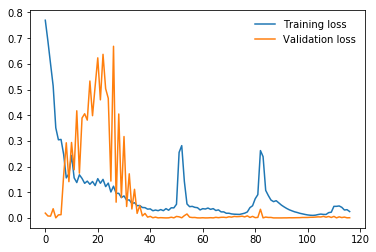

In [18]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)

## vaildation

In [19]:
eval_func(model, eval_dataset)

testing loss 4.56169800600037e-06


tensor(4.5617e-06, device='cuda:0')

### Submission

In [20]:
pred = test_func(model, X_test, y_scaler)
pred

In [ ]:

submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)

### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512